In [1]:
import spotipy
from matplotlib import pyplot as plt
from spotipy.oauth2 import SpotifyOAuth
import urllib
import spotipy.util as util
import numpy as np
import cv2
import json
import requests
import pandas as pd
from IPython.display import Image, display
from sklearn.cluster import KMeans

from datetime import datetime


In [2]:
# Spotify Credentials Setup
credentials = "spotify_keys.json"
with open(credentials, "r") as keys:
    api_tokens = json.load(keys)

client_id = api_tokens["client_id"]
client_secret = api_tokens["client_secret"]
redirectURI = api_tokens["redirect"]
username = api_tokens["username"]

In [3]:
# Set up Spotify Client with required scope for top tracks
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,
                                               client_secret=client_secret,
                                               redirect_uri=redirectURI,
                                               scope="user-top-read"))

In [4]:
# shopstyle Setup
with open('shopstyle_api.txt','r') as shop_file:
    shopstyle_key = shop_file.read()

In [5]:
# Function to download the album image and convert it to a color format usable by OpenCV
def url_to_image(url):
# download the image, convert it to a Numpy array, then reverse it into OpenCV formate
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image


In [6]:
# Function to create a histogram of colors in the image
def find_histogram(clt):
    """
    create a histogram with k clusters
    :param: clt
    :return:hist
    """
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)

    hist = hist.astype("float")
    hist /= hist.sum()

    return hist

In [7]:
# Function to plot the top colors
def plot_colors2(hist, centroids, song_title):
    bar = np.zeros((50, 300, 3), dtype="uint8")
    startX = 0

    for (percent, color) in zip(hist, centroids):
        # plot the realtive percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0),(int(endX), 50), color.astype("uint8").tolist(), -1)
        startX = endX

    # Display the color bar with the song title
    plt.figure(figsize=(8, 2))
    plt.axis("off")
    plt.title(f"Color Bar for '{song_title}'")
    plt.imshow(bar)
    plt.show()

In [8]:
# Function to get album colors from Spotify song
def get_album_colors(album_image_url,song_title):
    image = url_to_image(album_image_url)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.reshape((image.shape[0] * image.shape[1], 3))
    clt = KMeans(n_clusters=3)  # Cluster for top 3 colors
    clt.fit(image)
    hist = find_histogram(clt)
    return [tuple(map(int, color)) for color in clt.cluster_centers_]


# Function to display album colors from Spotify song
def display_album_colors(album_image_url,song_title):
    image = url_to_image(album_image_url)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.reshape((image.shape[0] * image.shape[1], 3))
    clt = KMeans(n_clusters=3)  # Cluster for top 3 colors
    clt.fit(image)
    hist = find_histogram(clt)
    # Show color bar for each song
    plot_colors2(hist, clt.cluster_centers_, song_title)  

In [9]:
# Test colorsys function
import colorsys
rgb=[255,0,0]
r, g, b = rgb[0] / 255, rgb[1] / 255, rgb[2] / 255
h, s, v = colorsys.rgb_to_hsv(r, g, b)

print(h,s,v)

0.0 1.0 1.0


In [10]:
# Function to convert RGB to color names (use hue to define the color range)
def rgb_to_color_name(rgb):
    import colorsys
    
    r, g, b = rgb[0] / 255, rgb[1] / 255, rgb[2] / 255
    h, s, v = colorsys.rgb_to_hsv(r, g, b)
    
    if v < 0.2:
        return "Black"
    elif v > 0.9 and s < 0.1:
        return "White"
    elif s < 0.1:
        return "Grey"
    
    # Convert hue from 0-1 to 0-360 for easier mapping
    hue_360 = h * 360

    # Define more refined ranges for colors
    if 0 <= hue_360 < 15 or 345 <= hue_360 <= 360:
        return "Red"
    elif 15 <= hue_360 < 30:
        return "Red-Orange"
    elif 30 <= hue_360 < 45:
        return "Orange"
    elif 45 <= hue_360 < 60:
        return "Yellow-Orange"
    elif 60 <= hue_360 < 90:
        return "Yellow"
    elif 90 <= hue_360 < 120:
        return "Yellow-Green"
    elif 120 <= hue_360 < 150:
        return "Green"
    elif 150 <= hue_360 < 180:
        return "Green-Cyan"
    elif 180 <= hue_360 < 210:
        return "Cyan"
    elif 210 <= hue_360 < 240:
        return "Blue-Cyan"
    elif 240 <= hue_360 < 270:
        return "Blue"
    elif 270 <= hue_360 < 300:
        return "Blue-Purple"
    elif 300 <= hue_360 < 330:
        return "Purple"
    elif 330 <= hue_360 < 345:
        return "Pink-Purple"
    else:
        return "Unknown color"

# print(rgb_to_color_name((165, 81, 75))) 
# print(rgb_to_color_name((252, 222, 239)))
# print(rgb_to_color_name((4, 3, 3)))

In [11]:
# Determine the current season based on current month
def get_current_season():
    month = datetime.now().month
    if month in [12, 1, 2]:
        return "winter"
    elif month in [3, 4, 5]:
        return "spring"
    elif month in [6, 7, 8]:
        return "summer"
    else:
        return "fall"
        
get_current_season()

'fall'

In [12]:
# List of sort options to experiment with
sort_options = ["popularity", "price", "price_desc", "new", "relevance"]

# Function to make an API call with a specific sort option
def test_sort_option(sort_value, gender="women", season="fall", color="black", limit=3):
    url = f"https://api.shopstyle.com/api/v2/products"
    params = {
        "pid": shopstyle_key,
        "fts": f"{gender} {season} {color} clothing",
        "offset": 0,
        "limit": limit,
        "sort": sort_value
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        print(f"Sort Option '{sort_value}': Success")
        data = response.json().get("products", [])
        if data:
            # Display product titles to verify results
            for item in data:
                print(f" - {item['name']} | Price: {item.get('priceLabel', 'N/A')}")
        else:
            print("No products found.")
    else:
        print(f"Sort Option '{sort_value}': Failed with status code {response.status_code}")

# Loop through each sort option and test it
for sort_value in sort_options:
    print(f"\nTesting Sort Option: {sort_value}")
    test_sort_option(sort_value)


Testing Sort Option: popularity
Sort Option 'popularity': Success
 - Falls Jumpsuit | Price: $118
 - Falling Poppies Petra Stretch Silk Button-Front Top | Price: $395
 - Marcia Jersey Midi Shirt Dress | Price: $130

Testing Sort Option: price
Sort Option 'price': Success
 - Falls Jumpsuit | Price: $118
 - Falling Poppies Petra Stretch Silk Button-Front Top | Price: $395
 - Marcia Jersey Midi Shirt Dress | Price: $130

Testing Sort Option: price_desc
Sort Option 'price_desc': Success
 - Falls Jumpsuit | Price: $118
 - Falling Poppies Petra Stretch Silk Button-Front Top | Price: $395
 - Marcia Jersey Midi Shirt Dress | Price: $130

Testing Sort Option: new
Sort Option 'new': Success
 - Falls Jumpsuit | Price: $118
 - Falling Poppies Petra Stretch Silk Button-Front Top | Price: $395
 - Marcia Jersey Midi Shirt Dress | Price: $130

Testing Sort Option: relevance
Sort Option 'relevance': Success
 - Falls Jumpsuit | Price: $118
 - Falling Poppies Petra Stretch Silk Button-Front Top | Price:

In [13]:
# ShopStyle API call to get outfit suggestions based on combined color names, gender, and season
def get_outfit_suggestions(combined_colors, gender, season, keyword="clothing", limit=5,sort_by="popularity"):
    if combined_colors in ["white gray black", "gray black white", "black gray white"]:
        combined_colors = "neutral tones"  # Use a broad, fashion-related term for neutral tones

    url = f"https://api.shopstyle.com/api/v2/products"
    params = {
        "pid": shopstyle_key,
        "fts": f"{gender} {season} {keyword} {combined_colors}",
        "offset": 0,
        "limit": limit,
        "sort": sort_by
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json().get("products", [])
    else:
        print("Error fetching outfits:", response.status_code)
        return []

In [14]:
# Modified display_outfits function with fallback to sample item if no outfits found
def display_outfits(outfits, color_names):
    # If no outfits are found, fetch a sample outfit in the primary color
    if not outfits:
        primary_color = color_names[0]  # Use the first color as the main color for the sample item
        print(f"No outfits found for color scheme: {', '.join(color_names).capitalize()}. Fetching a sample {primary_color} outfit...")
        outfits = get_sample_clothing_by_color(primary_color)

    # Display the outfits (whether from the original query or a sample)
    if outfits:
        print(f"Outfits for Color Scheme: {', '.join(color_names).capitalize()}")
        for item in outfits:
            title = item.get("name")
            price = item.get("priceLabel")
            brand = item.get("brand", {}).get("name")
            link = item.get("clickUrl")
            
            # Check if "image" is a dictionary, and extract the actual URL string
            image_data = item.get("image", "")
            image_url = image_data.get("sizes", {}).get("Original", {}).get("url") if isinstance(image_data, dict) else image_data
            
            # Display outfit details
            print(f"Title: {title}")
            print(f"Price: {price}")
            print(f"Brand: {brand}")
            print(f"Link: {link}")
            
            # Display image inline if image_url is available and is a string
            if isinstance(image_url, str) and image_url:
                display(Image(url=image_url, width=150))
            
            print("\n" + "-"*50 + "\n")  # Divider between items
    else:
        print(f"No sample outfits found for color scheme: {', '.join(color_names).capitalize()}")

In [15]:
# Function to get a sample black clothing item from ShopStyle API
def get_black_clothing_sample(gender="women", season="fall", keyword="black clothing", limit=1,sort_by="popularity"):
    url = f"https://api.shopstyle.com/api/v2/products"
    params = {
        "pid": shopstyle_key,
        "fts": f"{gender} {season} {keyword}",
        "offset": 0,
        "limit": limit,
        "sort": "popularity"
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json().get("products", [])
    else:
        print("Error fetching black clothing:", response.status_code)
        return []

# Testing the display_outfits function with a real black clothing item from ShopStyle
black_outfits = get_black_clothing_sample(gender="women", season="fall", keyword="black clothing",sort_by="popularity")
display_outfits(black_outfits, ["black"])


Outfits for Color Scheme: Black
Title: Falls Jumpsuit
Price: $118
Brand: vuori
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=953937704&pid=uid1241-46108024-89



--------------------------------------------------



In [16]:
# Helper function to get a sample clothing item by color from ShopStyle API
def get_sample_clothing_by_color(color, gender="women", season="fall", limit=1):
    url = f"https://api.shopstyle.com/api/v2/products"
    params = {
        "pid": shopstyle_key,
        "fts": f"{gender} {season} {color} clothing",
        "offset": 0,
        "limit": limit,
        "sort": "popularity"
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json().get("products", [])
    else:
        print(f"Error fetching {color} clothing:", response.status_code)
        return []


In [17]:
# Main function to get selected songs and color bars
def get_top_songs_colors():
    # Fetch user's top 3 tracks
    results = sp.current_user_top_tracks(limit=4)
    top_tracks = results['items']
    
    out_data = []
    print("Top 3 Selected Songs with Color Bars:")
    for track in top_tracks:
        track_name = track['name']
        artist_name = track['artists'][0]['name']
        album_image_url = track['album']['images'][0]['url']
        
        # Print the song and artist name
        print(f"\n'{track_name}' by {artist_name}")
        
        # Display color bar for each song
        colors = get_album_colors(album_image_url, track_name)
        color_names = [rgb_to_color_name(color) for color in colors]
        
        data = {
            "track_name":track_name,
            "artist_name":artist_name,
            "album_image_url":album_image_url,
            "colors":colors,
            "color_names":color_names
        }
        out_data.append(data)

    return out_data
# get_top_songs_colors return: out_data is a list.

top_songs_colors = get_top_songs_colors()
print(top_songs_colors)

Top 3 Selected Songs with Color Bars:

'Overcast' by Kevin MacLeod

'Espresso' by Sabrina Carpenter

'Viva La Vida' by Coldplay

'Video Games' by Lana Del Rey
[{'track_name': 'Overcast', 'artist_name': 'Kevin MacLeod', 'album_image_url': 'https://i.scdn.co/image/ab67616d0000b2735acd0df739682efabb292b87', 'colors': [(186, 91, 8), (251, 220, 238), (121, 60, 95)], 'color_names': ['Red-Orange', 'Purple', 'Purple']}, {'track_name': 'Espresso', 'artist_name': 'Sabrina Carpenter', 'album_image_url': 'https://i.scdn.co/image/ab67616d0000b273659cd4673230913b3918e0d5', 'colors': [(190, 205, 213), (42, 34, 36), (203, 136, 102)], 'color_names': ['Cyan', 'Black', 'Red-Orange']}, {'track_name': 'Viva La Vida', 'artist_name': 'Coldplay', 'album_image_url': 'https://i.scdn.co/image/ab67616d0000b273be592342bbc8e3bfce593b16', 'colors': [(209, 203, 193), (33, 27, 29), (125, 104, 86)], 'color_names': ['Grey', 'Black', 'Red-Orange']}, {'track_name': 'Video Games', 'artist_name': 'Lana Del Rey', 'album_imag

Song name: Overcast


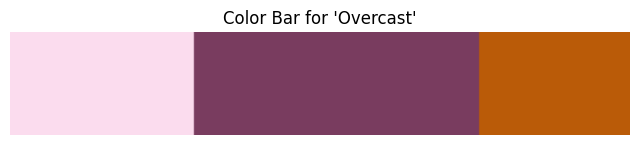

Song name: Espresso


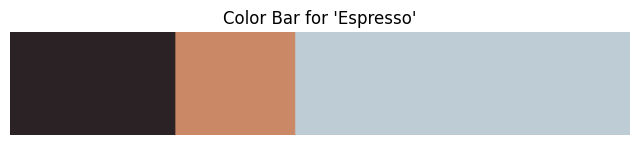

Song name: Viva La Vida


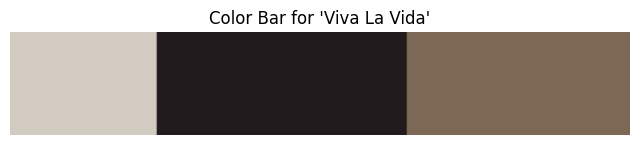

Song name: Video Games


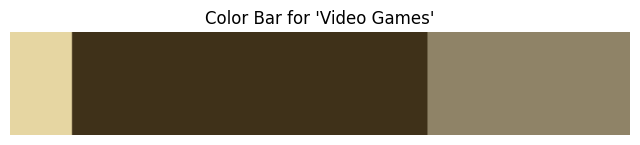

In [18]:
def display_top_songs_colors(in_data):
    for data in in_data:
        image_url = data["album_image_url"]
        print("Song name: " + data['track_name'])
        # display album pic
        if isinstance(image_url, str) and image_url:
            display(Image(url=image_url, width=200))
        # display album color bar
        display_album_colors(image_url, data["track_name"])

    
display_top_songs_colors(top_songs_colors)

In [19]:
# Generate and display outfit recommendations based on combined color scheme
def display_top_songs_colors_and_outfits(gender, in_data, sort_by="popularity"):
    for data in in_data:
        color_names = data["color_names"]
        combined_colors = " ".join(color_names)  # Combine color names into a single search term
        print(f"\nOutfit Recommendations for '{data['track_name']}' by {data['artist_name']} with colors {combined_colors.capitalize()}:")

        # First attempt with the full color scheme
        outfits = get_outfit_suggestions(combined_colors, gender, get_current_season(), sort_by=sort_by)
        # If no outfits found, try each color individually as a fallback
        if not outfits:
            print(f"No outfits found for color scheme: {combined_colors.capitalize()}. Trying broader search terms...")
            outfits = get_outfit_suggestions("neutral outfit" if "neutral" in combined_colors else combined_colors, gender, get_current_season())
                
            if outfits:
                display_outfits(outfits, [color_name])
            else:
                print(f"No outfits found even with broader search terms for: {', '.join(color_names).capitalize()}")
        else:
            display_outfits(outfits, color_names)

In [20]:
#  Display outfit recommendations based on combined color scheme
display_top_songs_colors_and_outfits("women",top_songs_colors,sort_by="new")  # Change "men" to "women" as needed



Outfit Recommendations for 'Overcast' by Kevin MacLeod with colors Red-orange purple purple:
Outfits for Color Scheme: Red-orange, purple, purple
Title: 24SEVEN COMFORT APPAREL 24/7 Comfort Apparel Midi Length Fit And Flare Pocket Dress
Price: $39.99
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=830306335&pid=uid1241-46108024-89



--------------------------------------------------

Title: Boxercraft Women's Baby Rib T-Shirt
Price: $128.52
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1072962963&pid=uid1241-46108024-89



--------------------------------------------------

Title: Women's Diana Ruched One-Shoulder Gown - Ivory - Size XXS
Price: $215
Brand: Norma Kamali
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=868914994&pid=uid1241-46108024-89



--------------------------------------------------

Title: GREGG Womens Drawstring Hooded Comfy Sweatshirt Solid Color Long Sleeve Pullover Shirts Holiday Party Loose Fall Sweatshirt(Red
Price: $20.99
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1005264838&pid=uid1241-46108024-89



--------------------------------------------------

Title: Geleglaer Womens Half Zip Sweatshirts Cropped Pullover Fleece Quarter Zipper Tops Spring Fall Hoodie outfits Thumb Hole
Price: $30.99
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1031483022&pid=uid1241-46108024-89



--------------------------------------------------


Outfit Recommendations for 'Espresso' by Sabrina Carpenter with colors Cyan black red-orange:
Outfits for Color Scheme: Cyan, black, red-orange
Title: BLAFT Women's Fashion Casual Valentine's Day Long Sleeve Sweatshirt Heart Print Plush Crew Neck Oversized Pullover Tops
Price: $20.57
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1005225106&pid=uid1241-46108024-89



--------------------------------------------------

Title: ZWSPTO Women's Floral Color Block Printed Long Sleeve Pullover Hoodies Sweatshirt Sweaters Tops Mint Green
Price: $22.99
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1029365276&pid=uid1241-46108024-89



--------------------------------------------------

Title: Swrowesi Crewneck Sweatshirts Half Zip Fall Fashion 2023 Mens Graphic T-Shirts Comfy Hoodie Sweatshirt for Men Plus Size Fashion Shirts for Men Graphic Hoodies for Men Casual Jackets for Men(1-Pink
Price: $24.41
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1006072021&pid=uid1241-46108024-89



--------------------------------------------------

Title: Kvsozwuty Men's Hoodies Pullover Black Hoodie Men Funny Hoodies Pullover Hoodie Men Men's Hoodies Full Zip Hoodies for Men Designer Hoodies for Men(5-Orange
Price: $23.23
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1024636716&pid=uid1241-46108024-89



--------------------------------------------------

Title: Kvsozwuty Hoodies for Men Mens Zip Up Hoodie Black Sweatshirt Matching Hoodies for Couples Mens Big and Tall Hoodies Christmas Hoodies for Men(2-Wine
Price: $20.17
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1022038081&pid=uid1241-46108024-89



--------------------------------------------------


Outfit Recommendations for 'Viva La Vida' by Coldplay with colors Grey black red-orange:
Outfits for Color Scheme: Grey, black, red-orange
Title: 24SEVEN COMFORT APPAREL 24/7 Comfort Apparel Midi Length Fit And Flare Pocket Dress
Price: $39.99
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=830306335&pid=uid1241-46108024-89



--------------------------------------------------

Title: Castelli Gabba RoS Jersey - Men's
Price: $239.99
Brand: Castelli
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=940490207&pid=uid1241-46108024-89



--------------------------------------------------

Title: Boxercraft Women's Baby Rib T-Shirt
Price: $128.52
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1072962963&pid=uid1241-46108024-89



--------------------------------------------------

Title: LAYHTKTL Fall Clothes For Women
Price: $30.69
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1005431819&pid=uid1241-46108024-89



--------------------------------------------------

Title: Generic Women'S Long Sleeve Sweatshirt Casual Crewneck Loose Fit Pullover Hoodie Fleece Fall Tops Large Burgundy
Price: $21.99
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1025713086&pid=uid1241-46108024-89



--------------------------------------------------


Outfit Recommendations for 'Video Games' by Lana Del Rey with colors Orange yellow-orange orange:
Outfits for Color Scheme: Orange, yellow-orange, orange
Title: Smak Parlour Plus Size 1960s Terry Cloth Romper - Fall brown, orange, yellow color
Price: $97
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1057540835&pid=uid1241-46108024-89



--------------------------------------------------

Title: BLISSY Silk Sleep Mask
Price: $39.95
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=896891483&pid=uid1241-46108024-89



--------------------------------------------------

Title: Women's Zip Front Puffer Oversized Jacket
Price: $128
Brand: Members Only
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=973580765&pid=uid1241-46108024-89



--------------------------------------------------

Title: State of Georgia The Lounger Rib Singlet Sunshine
Price: $69
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=897806537&pid=uid1241-46108024-89



--------------------------------------------------

Title: Smart and Joy Shoulder Flaps Woolen Coat - Orange
Price: $354
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1063791831&pid=uid1241-46108024-89



--------------------------------------------------



In [21]:
display_top_songs_colors_and_outfits("men",top_songs_colors,sort_by="popularity")


Outfit Recommendations for 'Overcast' by Kevin MacLeod with colors Red-orange purple purple:
Outfits for Color Scheme: Red-orange, purple, purple
Title: CUSTOMI Idaho Falls Idaho Adult Unisex Crewneck Sweatshirt
Price: $34.99
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1046244983&pid=uid1241-46108024-89



--------------------------------------------------

Title: Generic I'll Just Have the Chicken Tenders Sweatshirt Funny Graphic Farm Shirts I'll Have the Chicken Tenders Sweatshirt Long Sleeve Crew Neck Fall Pullover Top Chicken Tender Lover Hoodie Chartreuse
Price: $29.90
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1023748679&pid=uid1241-46108024-89



--------------------------------------------------

Title: CUSTOMI Great Falls Montana Adult Unisex Crewneck Sweatshirt
Price: $34.99
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1045116637&pid=uid1241-46108024-89



--------------------------------------------------

Title: CUSTOMI Sioux Falls South Dakota Adult Unisex Crewneck Sweatshirt
Price: $34.99
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1045360400&pid=uid1241-46108024-89



--------------------------------------------------

Title: Muscularfit black of friday deals 2023 Hoodies for Men Graphic Gradient Color Lightweight Hooded Sweatshirts Regular Fit Long Sleeve Drawstring Pullover mens plain hoodies Army Green 2X
Price: $45.59
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1024670418&pid=uid1241-46108024-89



--------------------------------------------------


Outfit Recommendations for 'Espresso' by Sabrina Carpenter with colors Cyan black red-orange:
Outfits for Color Scheme: Cyan, black, red-orange
Title: Swrowesi Crewneck Sweatshirts Half Zip Fall Fashion 2023 Mens Graphic T-Shirts Comfy Hoodie Sweatshirt for Men Plus Size Fashion Shirts for Men Graphic Hoodies for Men Casual Jackets for Men(1-Pink
Price: $24.41
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1006072021&pid=uid1241-46108024-89



--------------------------------------------------

Title: Kvsozwuty Men's Hoodies Pullover Black Hoodie Men Funny Hoodies Pullover Hoodie Men Men's Hoodies Full Zip Hoodies for Men Designer Hoodies for Men(5-Orange
Price: $23.23
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1024636716&pid=uid1241-46108024-89



--------------------------------------------------

Title: DYGUYTH Men's Funny Christmas Sweatshirts
Price: $20.99
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1026022307&pid=uid1241-46108024-89



--------------------------------------------------

Title: Kvsozwuty Hoodies for Men Mens Zip Up Hoodie Black Sweatshirt Matching Hoodies for Couples Mens Big and Tall Hoodies Christmas Hoodies for Men(2-Wine
Price: $20.17
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1022038081&pid=uid1241-46108024-89



--------------------------------------------------

Title: Kvsozwuty Mens Hoodies Pullover Men’s Sweatshirt Mens Hoodies Zip Up Short Sleeve Hoodies for Men Men's Hoodies Pullover Crewneck Sweatshirts Men Cool Hoodies for Men(4-Gray
Price: $20.37
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1030122481&pid=uid1241-46108024-89



--------------------------------------------------


Outfit Recommendations for 'Viva La Vida' by Coldplay with colors Grey black red-orange:
Outfits for Color Scheme: Grey, black, red-orange
Title: Swrowesi Crewneck Sweatshirts Half Zip Fall Fashion 2023 Mens Graphic T-Shirts Comfy Hoodie Sweatshirt for Men Plus Size Fashion Shirts for Men Graphic Hoodies for Men Casual Jackets for Men(1-Pink
Price: $24.41
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1006072021&pid=uid1241-46108024-89



--------------------------------------------------

Title: Generic I'll Just Have the Chicken Tenders Sweatshirt Funny Graphic Farm Shirts I'll Have the Chicken Tenders Sweatshirt Long Sleeve Crew Neck Fall Pullover Top Chicken Tender Lover Hoodie Chartreuse
Price: $29.90
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1023748679&pid=uid1241-46108024-89



--------------------------------------------------

Title: LCMTWX Cyber of Monday Deals 2023 Thermal Lined Zip Hoodie Sweatshirts Men Men Black Tshirt Hoodie Men Sweater Men Cotton 18000 Sweatshirt Blue Pullover Women Lightning Deals Of Today
Price: $20.29
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1004605892&pid=uid1241-46108024-89



--------------------------------------------------

Title: Kvsozwuty Men's Hoodies Pullover Black Hoodie Men Funny Hoodies Pullover Hoodie Men Men's Hoodies Full Zip Hoodies for Men Designer Hoodies for Men(5-Orange
Price: $23.23
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1024636716&pid=uid1241-46108024-89



--------------------------------------------------

Title: KXK Custom Full-Zip Hoodie Fleece Sweatshirt for Men & Women&Youth-Personalized Stitched Name Number Logo
Price: $28.99
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1003487130&pid=uid1241-46108024-89



--------------------------------------------------


Outfit Recommendations for 'Video Games' by Lana Del Rey with colors Orange yellow-orange orange:
Outfits for Color Scheme: Orange, yellow-orange, orange
Title: Generic Crewneck Sweatshirts Solide Color Long Sleeve Plain Mens Pullover Novelty Heated Matching Fall Sweatshirt Soft Adult Retro Mens Sweatshirts 02 Light Blue 4X-Large
Price: $21.12
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1021621699&pid=uid1241-46108024-89



--------------------------------------------------

Title: SAiden11 Men' Patchwork Outdoor Casual Sportswear Street Thermal Hooded Sweatshirt Fall Winter s4 Red L
Price: $42.77
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1028470466&pid=uid1241-46108024-89



--------------------------------------------------

Title: Generic Crewneck Sweatshirts Solide Color Long Sleeve Heated Pullover Sweatshirt College Soft Loose Fall Sweatshirts Retro Personalized Thermal Mens Sweatshirt 02 Gray 4X-Large
Price: $21.12
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1020688799&pid=uid1241-46108024-89



--------------------------------------------------

Title: Generic Mens Crewneck Sweatshirts Solide Color Long Sleeve Vintage Pullover Men Heavy Warm Oversized Fall Crewneck Sweatshirt Personalized Slim Fit College Men'S Sweatshirts 01 Light Brown 3X-Large
Price: $20.18
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1021663057&pid=uid1241-46108024-89



--------------------------------------------------

Title: Generic I'll Just Have the Chicken Tenders Sweatshirt Funny Graphic Farm Shirts I'll Have the Chicken Tenders Sweatshirt Long Sleeve Crew Neck Fall Pullover Top Chicken Tender Lover Hoodie Chartreuse
Price: $29.90
Brand: None
Link: https://api.shopstyle.com/action/apiVisitRetailer?id=1023748679&pid=uid1241-46108024-89



--------------------------------------------------

